## 15-9. 프로젝트 : 다양한 OCR모델 비교하기

우리는 지금까지 Google OCR API, keras-ocr, Tesseract 이상 3가지의 OCR 기능을 간단히 활용하여 보았습니다.

지금까지 살펴본 바로는 무료로 사용할 수 있는 기능들이지만 모두 준수한 성능을 갖추고 있었습니다. OCR 분야가 이미 실용적인 수준에까지 기술이 발전했기 때문에 이런 것들만 잘 활용해도 실전에 활용할 수 있는 좋은 서비스를 만들어 낼 수 있을 것도 같습니다. 그런데 과연 어떤 것을 사용하는 것이 좋을까요?

OCR 기술들이 실용적인 수준까지 꽤 발전했지만 그럼에도 불구하고 아직 완전한 수준은 아닙니다. 용도에 맞게 적절한 것을 선택하는 것도 중요한 일입니다. 그래서 오늘 다뤄본 위 3가지를 검증해 보는 프로젝트를 진행하겠습니다. 여러분은 OCR 기능을 활용한 서비스를 빠르게 개발해야 하는 임무를 맡은 엔지니어가 되어, 어떤 모듈을 도입하면 좋을지 기술검증을 하는 역할을 맡게 되었다고 가정합니다.

프로젝트를 시작하기 전에 주요 라이브러리 버전을 살펴보죠.

In [1]:
import keras_ocr
import pytesseract
import matplotlib.pyplot as plt

print(keras_ocr.__version__)
print(pytesseract.__version__)
# pytesseract는 tesseract-ocr에 종속적입니다. 아래 명령어를 통해 설치해야 할 수도 있습니다.
# !sudo apt install tesseract-ocr

0.8.8
0.3.8


###  Step0. 서비스 기획

자율주행에 있어서 표지판을 읽고 인공지능이 그것을 이해할 수 있도록 만들고자 한다. 

표지판 이미지를 잘 읽을 수 있는지 확인할 필요가 있다. 

### Step1. 검증용 데이터셋 준비

-----------------------------------------

OCR 관련해서 오늘 다루어본 주제는 텍스트의 모양과 크기, 배치, 노이즈 등 OCR의 성능에 영향을 미치는 요인들에 관한 것이었습니다. 여러분들은 위 3가지 기능들이 이미지에 나타난 특징에 따라 얼마나 정확하게 문자를 detect하고 recognize하는지를 검증하기 위한 이미지 데이터를 모아야 합니다. 이미지가 많을수록 좋겠지만 검증해야 할 항목별로 고루 갖춰지는 것도 중요합니다.

가능하다면 함께 학습하는 동료들과 힘을 합쳐보는 것을 추천합니다. 그렇다고 너무 많은 이미지 데이터로 검증하는 것은 이후 결과를 정리하는 것이 힘들 수 있으니 테스트용 이미지는 아무리 많아도 20장을 넘기지 않는 것으로 합시다.

In [2]:
import os
import cv2

In [29]:
# 테스트 이미지 경로 
work_dir = os.getenv('HOME')+'/aiffel/ocr_python/data/img'
file_list = os.listdir(work_dir)

In [30]:
file_list

['ocr01.png', 'ocr02.png', 'ocr04.png', 'ocr03.png']

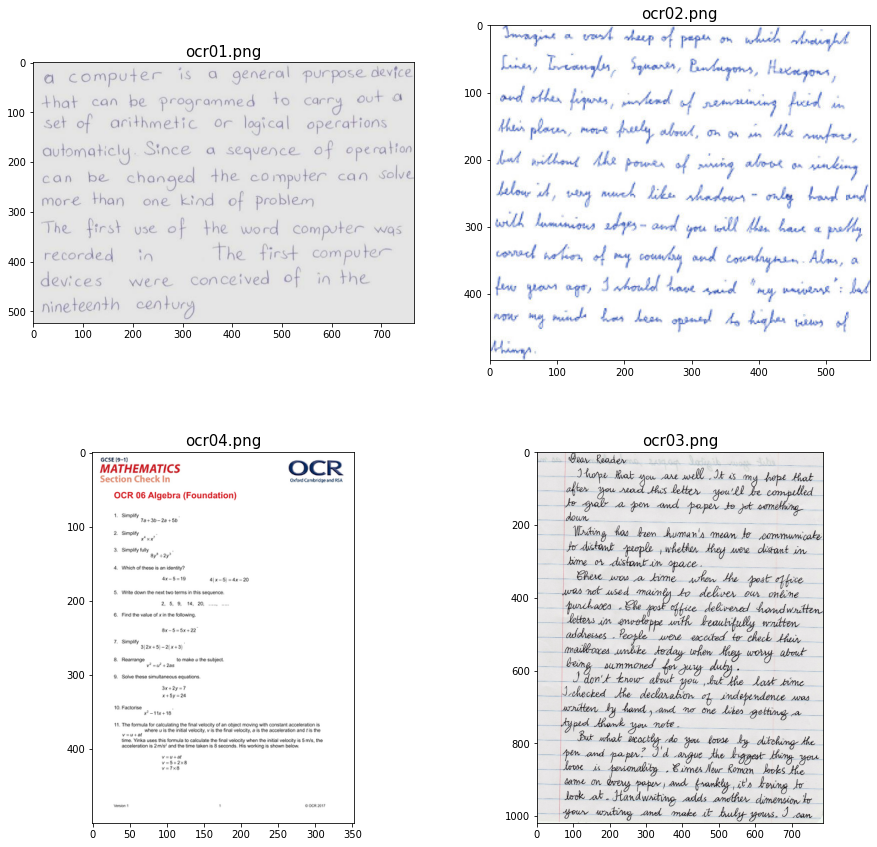

In [7]:
plt.figure(figsize=(15,15))
i=0
for file in file_list:
    plt.subplot(2,2,i+1)
    image_files = os.path.join(work_dir, file)
    image = cv2.imread(image_files)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    i += 1
    plt.title(file, fontsize=15)
    plt.imshow(image)

### Step2. keras-ocr, Tesseract로 테스트 진행(Google OCR API는 선택 사항)

--------------------------------------

위 두 가지 모듈을 활용하는 방법에 대해서는 코드 레벨로 이미 경험해 보셨을 것입니다. 이미지 리스트를 정리한 후 반복문을 실행하며 모듈이 출력한 결과를 모아 봅시다. 가능하다면 Google OCR API를 포함해 세 가지 모듈을 다 써보세요.

### Google OCR API

In [8]:
# 결과값을 dictionary에 담는다. 
google_ocr_dict = {}

# Text를 인식해서 출력하는 함수 
def detect_text(path, g_key):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print(type(texts))
    #print('Texts:')

    text_list = []
    for text in texts:
        text_list.append(text.description) # 출력된 text description을 리스트에 담기
        #print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))
    
    google_ocr_dict[g_key] = text_list # text list 결과물을 dictionary에 담기 
    
    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))

In [9]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
# !ls -l $GOOGLE_APPLICATION_CREDENTIALS

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/gentle-ally-368206-f848590bf65c.json'

# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
for file in file_list:
    image_files = os.path.join(work_dir, file)
    detect_text(image_files, file)

/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


<class 'proto.marshal.collections.repeated.RepeatedComposite'>
bounds: (312,470),(339,470),(338,508),(311,508)
<class 'proto.marshal.collections.repeated.RepeatedComposite'>
bounds: (512,429),(537,430),(536,461),(511,460)
<class 'proto.marshal.collections.repeated.RepeatedComposite'>
bounds: (302,473),(312,473),(312,476),(302,476)
<class 'proto.marshal.collections.repeated.RepeatedComposite'>
bounds: (709,990),(750,991),(750,1004),(709,1003)


In [10]:
for key in google_ocr_dict.keys():        
    print(f"[ {key} ]")
    str_value = ''
    for v in google_ocr_dict[key]:
        str_value += v
        str_value += ' '
    print(str_value)       
    print("------------------------")

[ ocr01.png ]
a computer is a general purpose device
that can be programmed to
set of arithmetic or logical operations
out a
carry
automaticly. Since a sequence of operation.
can be changed the computer can solve
one kind of problem
more than
The first use of the word computer was
recorded
The first computer
devices
were conceived of in the
nineteenth century. a computer is a general purpose device that can be programmed to set of arithmetic or logical operations out a carry automaticly . Since a sequence of operation . can be changed the computer can solve one kind of problem more than The first use of the word computer was recorded The first computer devices were conceived of in the nineteenth century . 
------------------------
[ ocr02.png ]
Imagine a vast sheep of paper on which straight.
Lines, Triangles, Squares, Pentagons, Hexagons,
and other figures, instead of remseining fixed in
their places, move
freely about, on or in the sunfors,
but without the power of riving above or si

### Keras-OCR

In [8]:
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


In [ ]:
# 파일리스트의 이미지 url을 가져와 text detect를 함. 평가를 위해 dictionary에 담음 
images = []
prediction_groups = []
keras_ocr_dict = {}
for i, file in enumerate(file_list):    
    image_files = os.path.join(work_dir, file)
    images.append(keras_ocr.tools.read(image_files)) 
    prediction_groups.append(pipeline.recognize([image_files]))
    
    text_list = []
    for j in range(len(prediction_groups[i][0])):
        text_list.append(prediction_groups[i][0][j][0])
        
    keras_ocr_dict[file] = text_list

In [ ]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

> 커널이 계속 죽어서 확인 불가

### Tesseract

In [4]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            #print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list

In [5]:
# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
def recognize_images(cropped_image_path_list, file):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    text_list = []
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng', # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        text_list.append(recognized_data['text'].replace('\n\x0c',''))
        #print(recognized_data['text'])
    print(f"{file} -  Done")
    
    return text_list

In [6]:
tesseract_dict = {}
for i, file in enumerate(file_list):
    image_files = os.path.join(work_dir, file)
    output_dir = work_dir + '/output_' + str(i)
    cropped_image_path_list = crop_word_regions(image_files, output_dir)   
    tesseract_dict[file] = recognize_images(cropped_image_path_list, file)

ocr01.png -  Done
ocr02.png -  Done
ocr04.png -  Done
ocr03.png -  Done


### Step3. 테스트 결과 정리

---------------------------------

모듈들마다 출력 형태가 다릅니다. 분석을 위해 결과를 일목요연하게 정리해 보는 것이 도움이 될 것입니다. 시각화 방법이 함께 활용된다면 더욱 좋겠군요.

In [11]:
def image_show(idx):
    plt.figure(figsize=(8, 10))
    image_files = os.path.join(work_dir, file_list[idx])
    image = cv2.imread(image_files)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.axis('off')
    plt.imshow(image)

Google OCR API : 
 ['a', 'computer', 'is', 'a', 'general', 'purpose', 'device', 'that', 'can', 'be', 'programmed', 'to', 'set', 'of', 'arithmetic', 'or', 'logical', 'operations', 'out', 'a', 'carry', 'automaticly', '.', 'Since', 'a', 'sequence', 'of', 'operation', '.', 'can', 'be', 'changed', 'the', 'computer', 'can', 'solve', 'one', 'kind', 'of', 'problem', 'more', 'than', 'The', 'first', 'use', 'of', 'the', 'word', 'computer', 'was', 'recorded', 'The', 'first', 'computer', 'devices', 'were', 'conceived', 'of', 'in', 'the', 'nineteenth', 'century', '.']
------------------
Tesseract : 
 ['C)', 'computer', '1S', 'C)', 'general', 'PUr Pose', '_ device', '+hat', 'COT)', 'be', 'programmed', '+c', 'core et', 'Out', 'Ot', 'set', 'of', 'arithmetic', 'Or', 'Jogi cq |', 'operations', 'automaticly', 'Stnce', 'C\\', 'SCOVENCEe', 'o+', 'operation', 'CON', 'be', 'ana Aea', '+he.', 'CO mputer', 'Caf)', 'Solve.', 'Norte', 'than', 'Or) &.', 'king', 'ot', 'Problem', 'yhe.', 'Pirst', 'WYSE', 'o +', 'Lhe

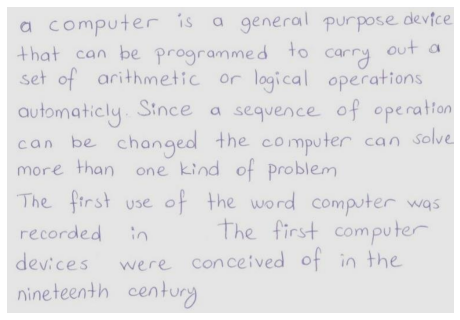

In [23]:
image_show(0)
ocr_img = 'ocr01.png'
print(f"Google OCR API : \n {google_ocr_dict[ocr_img][1:]}")
print("------------------")
# print(f"Keras-ocr : \n {keras_ocr_dict['ocr01.png']}")
# print("------------------")
print(f"Tesseract : \n {tesseract_dict[ocr_img]}")
print("------------------")

Google OCR API : 
 ['Imagine', 'a', 'vast', 'sheep', 'of', 'paper', 'on', 'which', 'straight', '.', 'Lines', ',', 'Triangles', ',', 'Squares', ',', 'Pentagons', ',', 'Hexagons', ',', 'and', 'other', 'figures', ',', 'instead', 'of', 'remseining', 'fixed', 'in', 'their', 'places', ',', 'move', 'freely', 'about', ',', 'on', 'or', 'in', 'the', 'sunfors', ',', 'but', 'without', 'the', 'power', 'of', 'riving', 'above', 'or', 'sinking', 'much', 'like', 'shadows', '-', 'only', 'hard', 'and', 'will', 'then', 'have', 'a', 'pretty', 'below', 'it', ',', 'very', 'with', 'luminious', 'edges', '-', 'and', 'a', 'correct', 'notion', 'of', 'my', 'country', 'and', 'countrymen', '.', 'Alas', ',', 'I', 'should', 'have', 'said', '"', 'my', 'universe', '"', ':', 'but', 'few', 'years', 'ago', ',', 'now', 'my', 'things', '.', 'minds', 'has', 'been', 'opened', 'to', 'higher', 'views', 'of']
------------------
Tesseract : 
 ['a', 'i', 'dks', 'Powe', '\x0c', 'mowing', 'ates', 'a', 'soning', 'sebo', '4,', 'é', 're

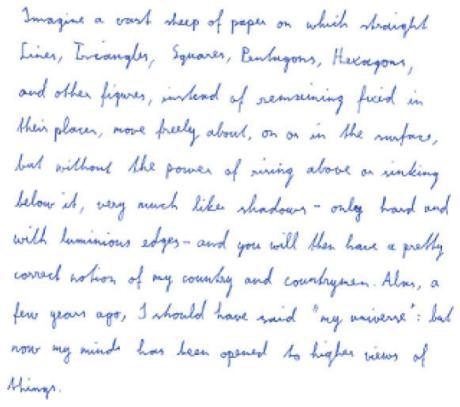

In [22]:
image_show(1)
ocr_img = 'ocr02.png'
print(f"Google OCR API : \n {google_ocr_dict[ocr_img][1:]}")
print("------------------")
# print(f"Keras-ocr : \n {keras_ocr_dict['ocr01.png']}")
# print("------------------")
print(f"Tesseract : \n {tesseract_dict[ocr_img]}")
print("------------------")

Google OCR API : 
 ['GCSE', '(', '9-1', ')', 'MATHEMATICS', 'Section', 'Check', 'In', 'OCR', '06', 'Algebra', '(', 'Foundation', ')', '1.', 'Simplify', '2.', 'Simplify', '7a', '+', '36-20-56', '3.', 'Simplify', 'fully', '4.', 'Which', 'of', 'these', 'is', 'an', 'identity', '?', '4x', '-', '5-19', '5.', 'Write', 'down', 'the', 'next', 'two', 'terms', 'in', 'this', 'sequence', '.', '2.', '5.', 'R.', '14', ',', '20', ',', '6.', 'Find', 'the', 'value', 'of', 'x', 'in', 'the', 'following', '.', 'Bang', 'Bạt', '7.', 'Simplify', '3', '(', '2x', '+', '5', ')', '-2', '(', 'x', '+', '3', ')', '8.', 'Rearrange', '9.', 'Solve', 'these', 'simultaneous', 'equations', '.', '10.', 'Factorise', 'to', 'make', 'the', 'subject', '.', '4x', '-', '5', ')', '-4x', '-', '20', '3x', '+', '2y', '=', '7', 'x', '+', '5y', '=', '24', 'OCR', 'Oxford', 'Cambridge', 'and', 'RSA', 'x²', '-', '11x', '+', '18', '11.', 'The', 'formula', 'for', 'calculating', 'the', 'final', 'velocity', 'of', 'an', 'object', 'moving', 'wi

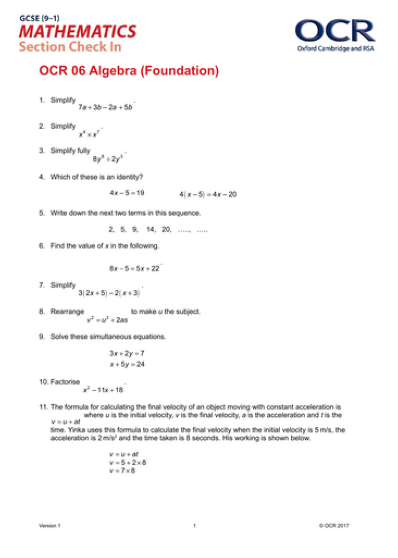

In [25]:
image_show(2)
ocr_img = 'ocr04.png'
print(f"Google OCR API : \n {google_ocr_dict[ocr_img][1:]}")
print("------------------")
# print(f"Keras-ocr : \n {keras_ocr_dict['ocr01.png']}")
# print("------------------")
print(f"Tesseract : \n {tesseract_dict[ocr_img]}")
print("------------------")

Google OCR API : 
 ['in', 'in', 'Gear', 'Reader', 'well', '..', 'It', 'is', 'are', '-', 'read', 'this', 'letter', "you'll", 'be', 'compelled', 'my', 'hope', 'that', 'AUON', 'I', 'hope', 'that', 'after', 'you', 'read', 't', 'you', 'to', 'grab', 'a', 'pen', 'and', 'paper', 'to', 'jot', 'something', 'down', 'Writing', 'has', 'been', "human's", 'mean', 'to', 'communicate', 'to', 'distant', 'people', ',', 'whether', 'they', 'were', 'distant', 'in', 'space', '.', 'time', 'or', 'distant', 'in', 'There', 'was', 'a', 'time', 'when', 'the', 'post', 'office', 'was', 'not', 'used', 'mainly', 'to', 'deliver', 'our', 'online', 'purchases', '.', 'The', 'post', 'office', 'delivered', 'handwritten', 'letters', 'in', 'envoloppe', 'with', 'beautifully', 'written', 'addresses', '.', 'People', 'were', 'exccited', 'to', 'check', 'their', 'mailboxes', 'unlike', 'to', 'day', 'when', 'they', 'worry', 'about', 'being', 'summoned', 'for', 'jury', 'duty', '.', 'I', "don't", 'know', 'about', 'you', 'but', 'the', '

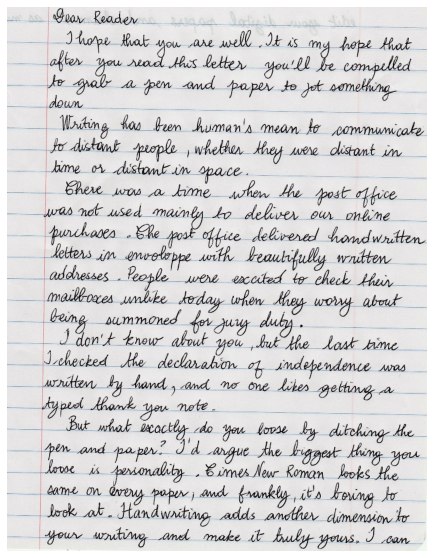

In [32]:
image_show(3)
ocr_img = 'ocr03.png'
print(f"Google OCR API : \n {google_ocr_dict[ocr_img][1:]}")
print("------------------")
# print(f"Keras-ocr : \n {keras_ocr_dict['ocr01.png']}")
# print("------------------")
print(f"Tesseract : \n {tesseract_dict[ocr_img]}")
print("------------------")

### Step4. 결과 분석과 결론 제시

--------------------------------------

우선 여러분들이 구현하고자 하는 서비스의 목적과 내용을 먼저 정리합니다. 여러분들이 검토한 OCR 모델들이 그 목적에 부합하는지 확인하기 위해 필요한 평가 기준을 제시합니다. 그 기준에 따라 위에서 정리한 테스트 결과를 분석하여 가장 나은 대안의 모델을 선정합니다.

__결론__

>Google OCR API가 가장 우수한 성능을 보여준다.

우선 세 개의 모델 중에서 keras 모델은 작동하지 않았다. 정확히 말하면 알 수 없는 이유로 커널이 자꾸 사망하였다. 
또한 tesseract 모델은 정상적으로 잘 작동하였지만 성능은 googledp 비해서 많이 부족했다. 정자로 쓰여진 영어 필기 글씨는 잘 인식했지만 영어 필기체와 수학기호는 거의 알아보지 못하는 수준이었다.

반면 Google OCR API는 모든 부분에서 완벽하게 인식하는 수준이었다. 

### 회고

가장 실용적이고 재미있는 작업이었다. OCR 모델을 직접 만들어 보기도 하고 이미 만들어진 모델을 불러와서 사용하는 방법도 익혔다. 아마도 지금까지 배운것 중에서 가장 성능이 좋고 실용적으로 활용할만한 기술로 생각이 된다. 과거에 모바일 앱을 만들어보려고 시도할때 OCR 기술이 필요했었는데 그때는 이것을 알지 못했다. 앞으로 창업을 하게 되면 Google OCR API를 활용하면 손쉽게 OCR 기술을 도입할 수 있을것으로 보인다, 